# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [28]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [29]:
#!pip install numpy==1.23.5
#!pip install Cython
#!pip install pmdarima

## 1. Cargamos los datos

In [30]:
# Import as Dataframe de consumo de fármacos
df = pd.read_csv('data/df_furniture2.csv')
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     331 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


## 2. Tratar la fecha como texto y parsear

In [32]:
# Date in Index
df = pd.read_csv('data/df_furniture2.csv', parse_dates = ['Month'])
df.head()


,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     331 non-null    datetime64[ns]
 1   furniture_price_adjusted  331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


## 3. ¿De qué fecha a qué fecha va el histórico?

In [34]:
# Obtener la fecha mínima y máxima
fecha_minima = df['Month'].min()
fecha_maxima = df['Month'].max()

# Imprimir el rango de fechas
print(f"El histórico va desde {fecha_minima} hasta {fecha_maxima}.")


El histórico va desde 1992-01-01 00:00:00 hasta 2019-07-01 00:00:00.


## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

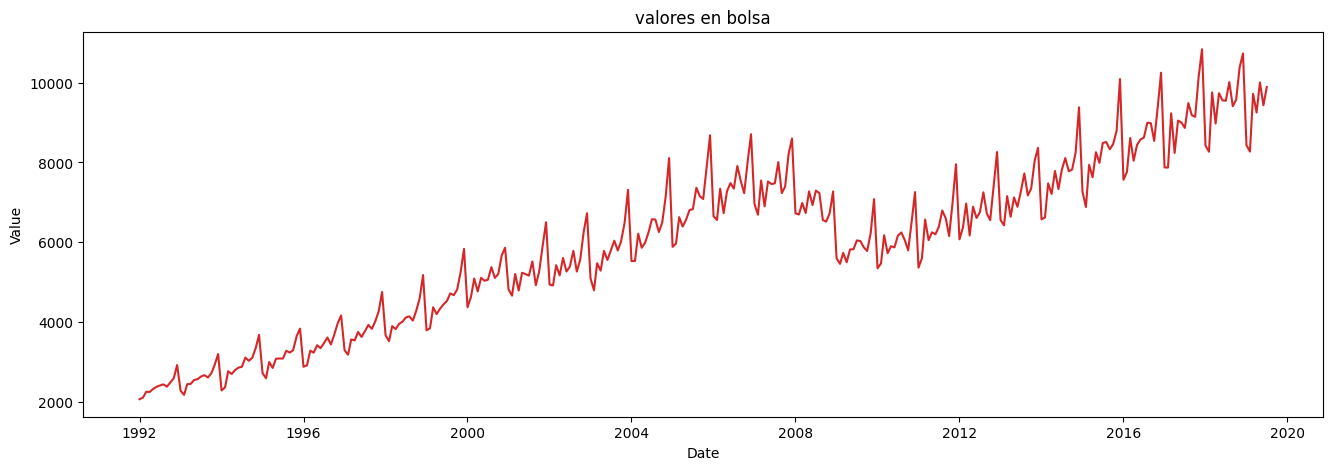

In [35]:
df = pd.read_csv('data/df_furniture2.csv', parse_dates=['Month'], index_col='Month')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.furniture_price_adjusted, title='valores en bolsa') 

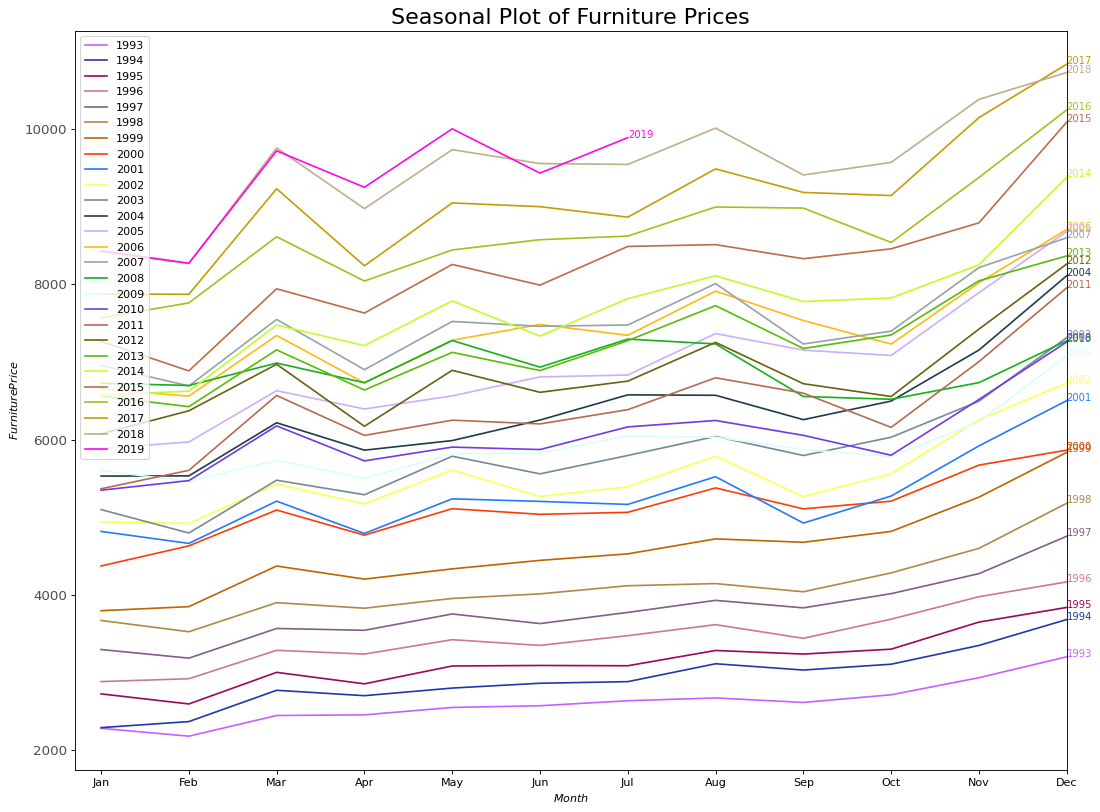

In [36]:
# Import Data from the uploaded CSV file
df = pd.read_csv('data/df_furniture2.csv', parse_dates=['Month'], index_col='Month')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.Month]
df['month'] = [d.strftime('%b') for d in df.Month]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16, 12), dpi=80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'furniture_price_adjusted', data=df.loc[df.year == y, :], color=mycolors[i], label=y)
        plt.text(
            df.loc[df.year == y, :].shape[0] - 1, 
            df.loc[df.year == y, 'furniture_price_adjusted'].iloc[-1], 
            str(y), fontsize=9, color=mycolors[i]
        )

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylabel='$Furniture Price$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Furniture Prices", fontsize=20)
plt.legend(loc='upper left', fontsize=10)
plt.show()


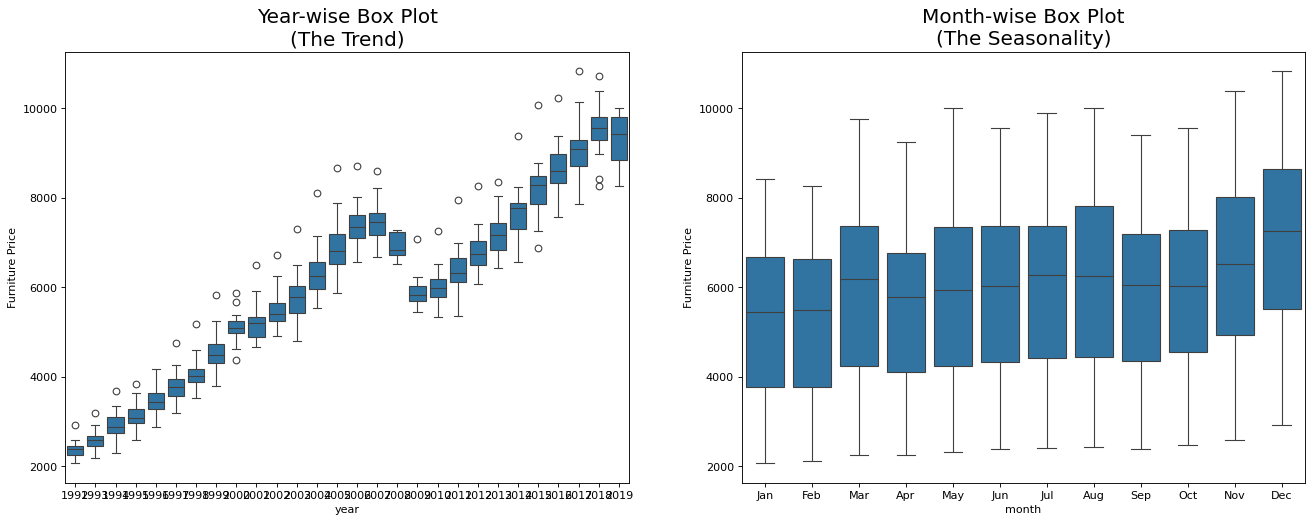

In [37]:
# Import Data
df = pd.read_csv('data/df_furniture2.csv', parse_dates=['Month'], index_col='Month')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.Month]
df['month'] = [d.strftime('%b') for d in df.Month]

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)

# Year-wise Box Plot
sns.boxplot(x='year', y='furniture_price_adjusted', data=df, ax=axes[0])
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
axes[0].set_ylabel('Furniture Price')

# Month-wise Box Plot (exclude years if needed)
sns.boxplot(x='month', y='furniture_price_adjusted', data=df)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].set_ylabel('Furniture Price')

# Show Plot
plt.show()


## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

In [38]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('data/df_furniture2.csv', parse_dates=['Month'])

result = adfuller(df['furniture_price_adjusted'].values)
result[1]

0.7035529748089981

Es mayor que 0.05, lo que significa que no podemos rechazar la hipótesis nula.
Por lo tanto, la serie de precios ajustados de muebles no es estacionaria.

In [39]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('data/df_furniture2.csv', parse_dates=['Month'])

result = kpss(df['furniture_price_adjusted'].values)
result[1]

C:\Users\mikel\AppData\Local\Temp\ipykernel_20000\112690.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df['furniture_price_adjusted'].values)


0.01

Es menor que 0.05, lo que significa que rechazamos la hipótesis nula.
Por lo tanto, la serie de precios ajustados de muebles no es estacionaria según el test KPSS.

## 6. ¿Conoces algún método para representar mejor la tendencia?

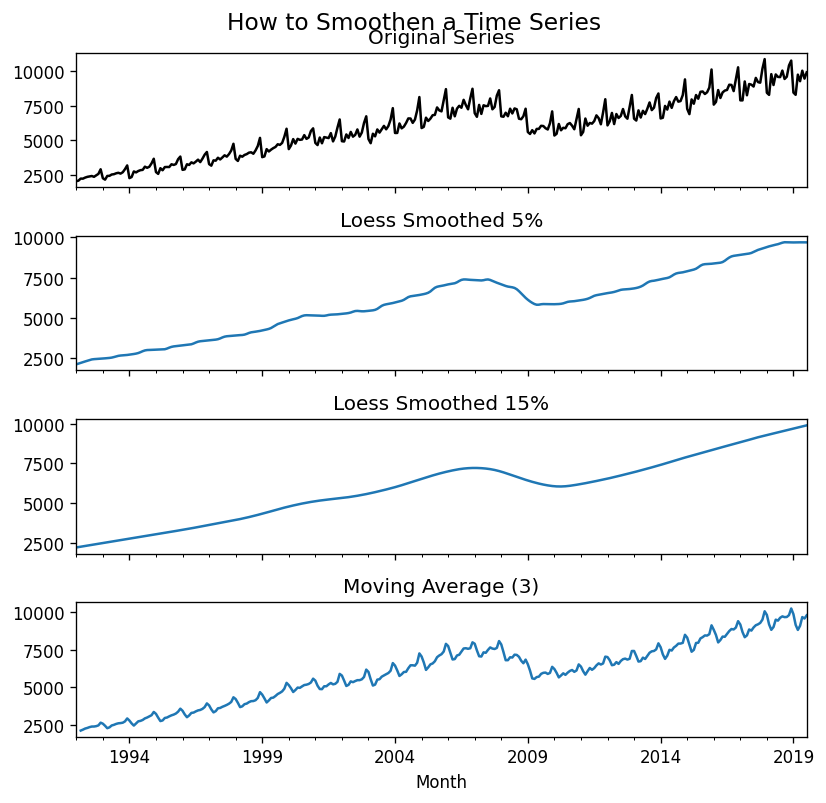

In [40]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Import data
file_path = 'data/df_furniture2.csv'
df = pd.read_csv(file_path, parse_dates=['Month'], index_col='Month')

# 1. Moving Average
df_ma = df['furniture_price_adjusted'].rolling(3).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df['furniture_price_adjusted'], np.arange(len(df['furniture_price_adjusted'])), frac=0.05)[:, 1],
                          index=df.index, columns=['furniture_price_adjusted'])
df_loess_15 = pd.DataFrame(lowess(df['furniture_price_adjusted'], np.arange(len(df['furniture_price_adjusted'])), frac=0.15)[:, 1],
                           index=df.index, columns=['furniture_price_adjusted'])

# Plot
fig, axes = plt.subplots(4, 1, figsize=(7, 7), sharex=True, dpi=120)
df['furniture_price_adjusted'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['furniture_price_adjusted'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['furniture_price_adjusted'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.tight_layout()
plt.show()


## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

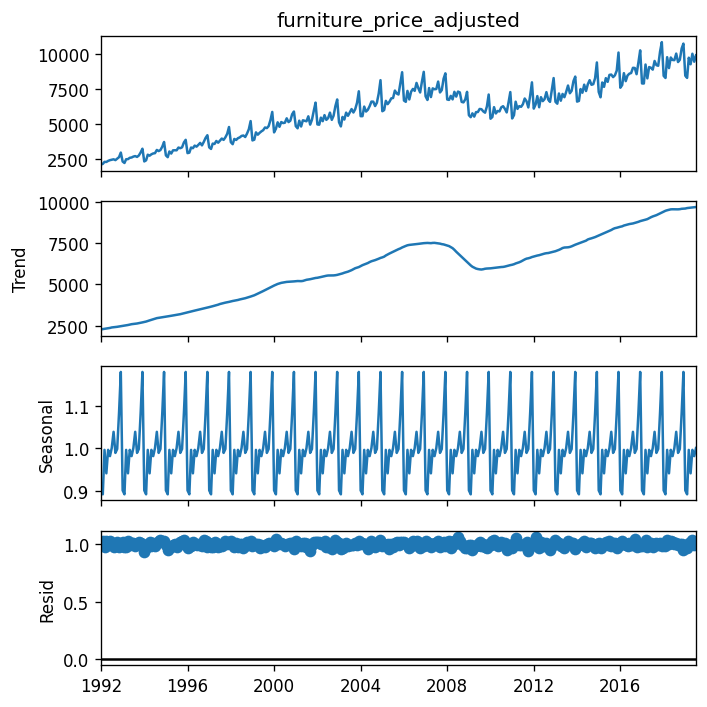

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('data/df_furniture2.csv', parse_dates=['Month'], index_col='Month')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['furniture_price_adjusted'], model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(df['furniture_price_adjusted'], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul.plot();

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

<Figure size 1200x720 with 0 Axes>

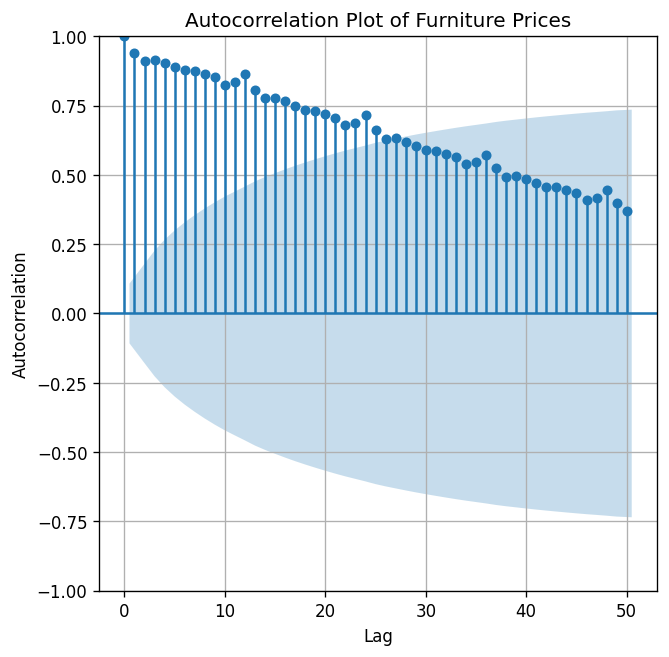

In [42]:
from statsmodels.graphics.tsaplots import plot_acf

# Import Data
file_path = 'data/df_furniture2.csv'
df = pd.read_csv(file_path, parse_dates=['Month'], index_col='Month')

# Extract the relevant series
series = df['furniture_price_adjusted']

# Plot Autocorrelation
plt.figure(figsize=(10, 6))
plot_acf(series, lags=50, alpha=0.05)
plt.title('Autocorrelation Plot of Furniture Prices')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

## 9. ¿Qué dependencia tiene cada instante de sus últimos 5 lags? Demuéstralo mediante una matriz de correlación.

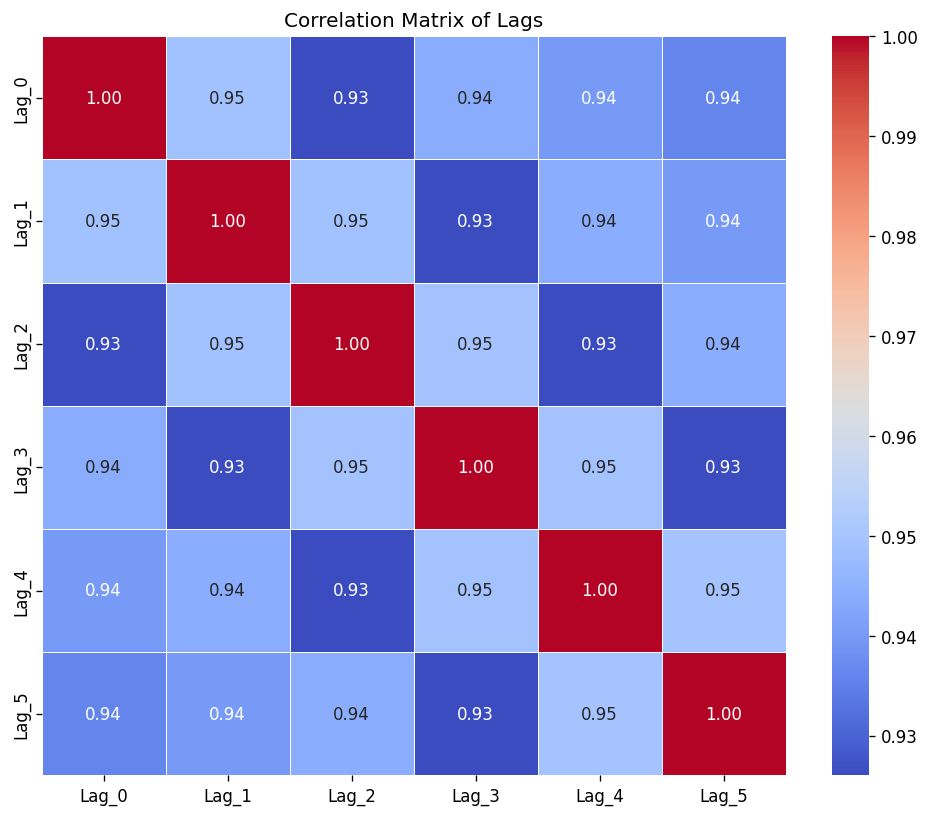

In [43]:
# Crear un DataFrame con la serie original y sus últimos 5 lags
df_lags = pd.DataFrame({'Lag_0': series})
for lag in range(1, 6):
    df_lags[f'Lag_{lag}'] = series.shift(lag)

# Eliminar filas con valores NaN (debido a los desplazamientos)
df_lags.dropna(inplace=True)

# Calcular la matriz de correlación
correlation_matrix = df_lags.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Lags')
plt.show()

Si los valores en las diagonales superiores son altos (cercanos a 1), se evidencia una fuerte dependencia en los lags respectivos.

## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

In [44]:
from statsmodels.tsa.stattools import acf

# Calcular los valores de autocorrelación
autocorr_values = acf(series, nlags=50, fft=True)

# Encontrar los picos en los valores de autocorrelación
from scipy.signal import find_peaks
peaks, _ = find_peaks(autocorr_values, height=0.1)  # height establece un umbral para picos significativos

# Imprimir los lags donde se encuentran los picos
print("Picos de autocorrelación encontrados en los siguientes lags:", peaks)

# Periodicidad
if len(peaks) > 1:
    periodicity = np.diff(peaks).mean()
    print(f"El patrón de estacionalidad se repite aproximadamente cada {periodicity:.2f} instantes.")
else:
    print("No se encontraron suficientes picos para determinar la periodicidad.")


Picos de autocorrelación encontrados en los siguientes lags: [ 3 12 15 24 27 36 39 48]
El patrón de estacionalidad se repite aproximadamente cada 6.43 instantes.


Picos: Los lags donde se encuentran los picos significativos indican la periodicidad de la serie.
Periodicidad: Si los picos están distribuidos regularmente, su diferencia promedio indica cada cuántos instantes se repite el patrón.

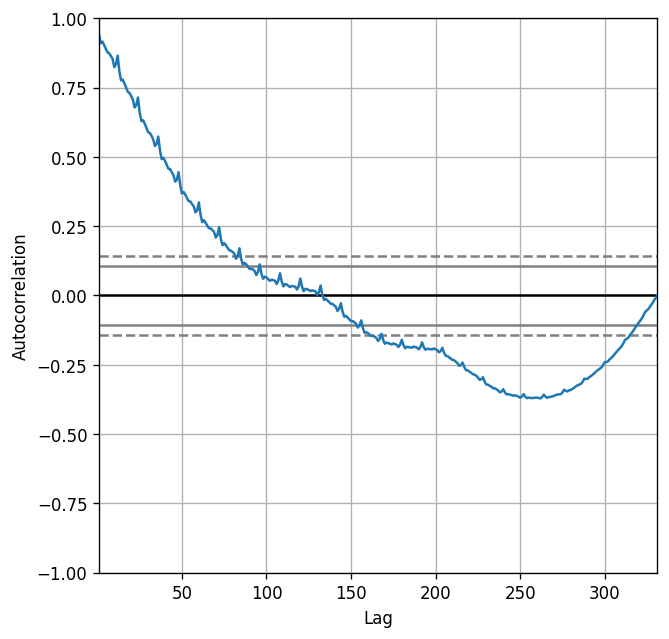

In [45]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.furniture_price_adjusted.values);

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

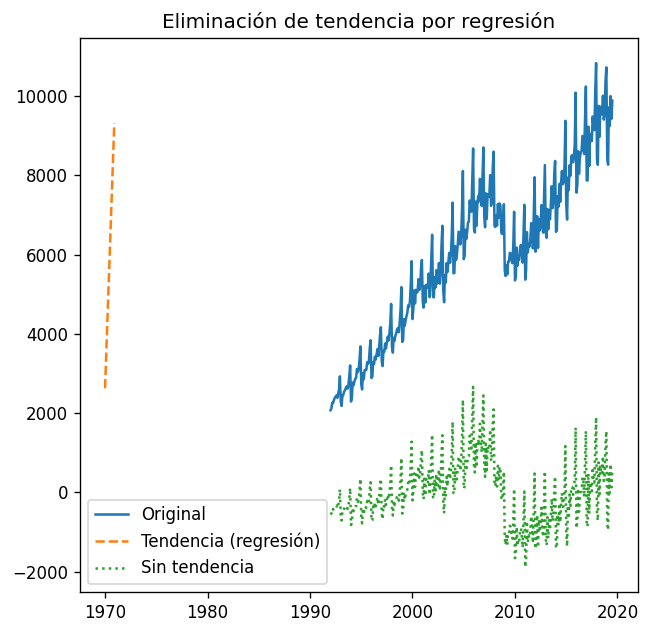

In [46]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo de regresión
X = np.arange(len(df)).reshape(-1, 1)
y = df['furniture_price_adjusted']
model = LinearRegression()
model.fit(X, y)

# Estimar la tendencia
trend = model.predict(X)

# Eliminar la tendencia
df['detrended'] = df['furniture_price_adjusted'] - trend

# Visualizar
plt.plot(df['furniture_price_adjusted'], label='Original')
plt.plot(trend, label='Tendencia (regresión)', linestyle='--')
plt.plot(df['detrended'], label='Sin tendencia', linestyle=':')
plt.legend()
plt.title("Eliminación de tendencia por regresión")
plt.show()


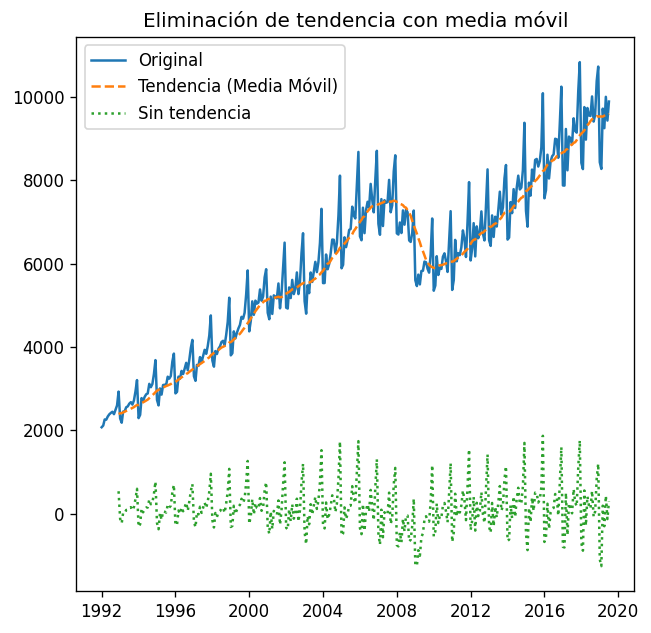

In [47]:
# Suavizado por media móvil
rolling_mean = df['furniture_price_adjusted'].rolling(window=12).mean()
df['detrended_ma'] = df['furniture_price_adjusted'] - rolling_mean

# Visualizar
plt.plot(df['furniture_price_adjusted'], label='Original')
plt.plot(rolling_mean, label='Tendencia (Media Móvil)', linestyle='--')
plt.plot(df['detrended_ma'], label='Sin tendencia', linestyle=':')
plt.legend()
plt.title("Eliminación de tendencia con media móvil")
plt.show()


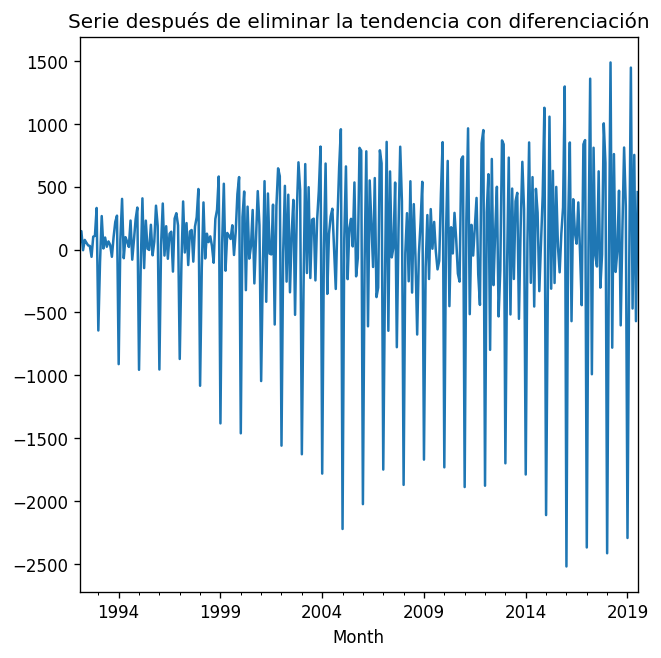

In [48]:
# Diferenciación
df['differenced'] = df['furniture_price_adjusted'].diff()

# Eliminar el primer NaN después de la diferenciación
df_differenced = df['differenced'].dropna()

# Visualizar
df_differenced.plot(title="Serie después de eliminar la tendencia con diferenciación")
plt.show()
